# Simple Multi-Period Rankine Cycle with Price Taker Market Interaction

#### This example demonstrates how to use the MultiPeriod class to extend steady-state models to multiple time periods. We specifically show how a steady-state rankine cycle could be extended to use battery storage and track market price signals

First, we load necessary packages including rankine cycle and multiperiod functions

In [1]:
import pyomo.environ as pyo
import numpy as np
import copy
from random import random

#For plots
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rc('font', size=24)
plt.rc('axes', titlesize=24)

#import multiperiod object and rankine example
from idaes.apps.multiperiod.multiperiod import MultiPeriodModel
from idaes.apps.rankine.simple_rankine_cycle import create_model,\
set_inputs, initialize_model, close_flowsheet_loop, add_operating_cost, add_capital_cost

# 1.) Create Steady-State Rankine Cycle Model

Create a function that returns a steady-state pyomo model for a rankine cycle. This could be exchanged for a more detailed plant model.

In [2]:
def create_ss_rankine_model():
    p_lower_bound = 300 #MW
    p_upper_bound = 450 #MW

    m = pyo.ConcreteModel()
    m.rankine = create_model(heat_recovery=True)
    m.rankine = set_inputs(m.rankine)
    m.rankine = initialize_model(m.rankine)
    m.rankine = close_flowsheet_loop(m.rankine)
    m.rankine = add_operating_cost(m.rankine)

    # set bounds for net cycle power output 
    m.rankine.fs.eq_min_power = pyo.Constraint(
        expr=m.rankine.fs.net_cycle_power_output >= p_lower_bound*1e6)

    m.rankine.fs.eq_max_power = pyo.Constraint(
        expr=m.rankine.fs.net_cycle_power_output <= p_upper_bound*1e6)

    m.rankine.fs.boiler.inlet.flow_mol[0].unfix()  #normally fixed 
    m.rankine.fs.boiler.inlet.flow_mol[0].setlb(1) #setting 0 causes numerical issues

    return m

# 2.) Import Locational Marginal Price (LMP) Data

We use representative prices from a Prescient simulation over the course of an entire year in the RTS-GMLC test system. We fix price spikes to $200/MWh since Prescient does not calculate prices for un-met load

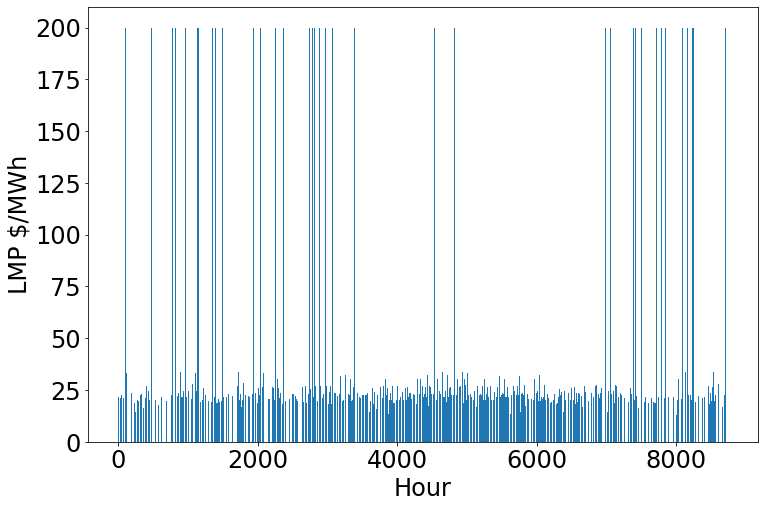

In [4]:
with open('rts_results_all_prices.npy', 'rb') as f:
    dispatch = np.load(f)
    price = np.load(f)
    
plt.figure(figsize=(12,8));
prices_used = copy.copy(price);
prices_used[prices_used > 200] = 200;
x = list(range(0,len(prices_used)));
plt.bar(x,(prices_used));
plt.xlabel("Hour");
plt.ylabel("LMP $/MWh");

## LMP for 6 Representative Weeks

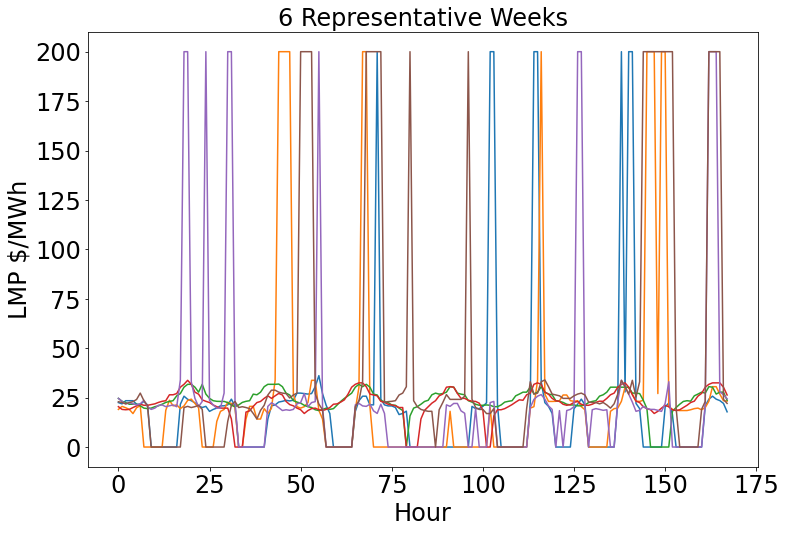

In [5]:
weekly_prices = prices_used.reshape(52,168);
plt.figure(figsize=(12,8));
for week in [0,15,25,35,45,51]:
    plt.plot(weekly_prices[week]);
plt.title("6 Representative Weeks")
plt.xlabel("Hour");
plt.ylabel("LMP $/MWh");

## LMP for 52 Representative Weeks

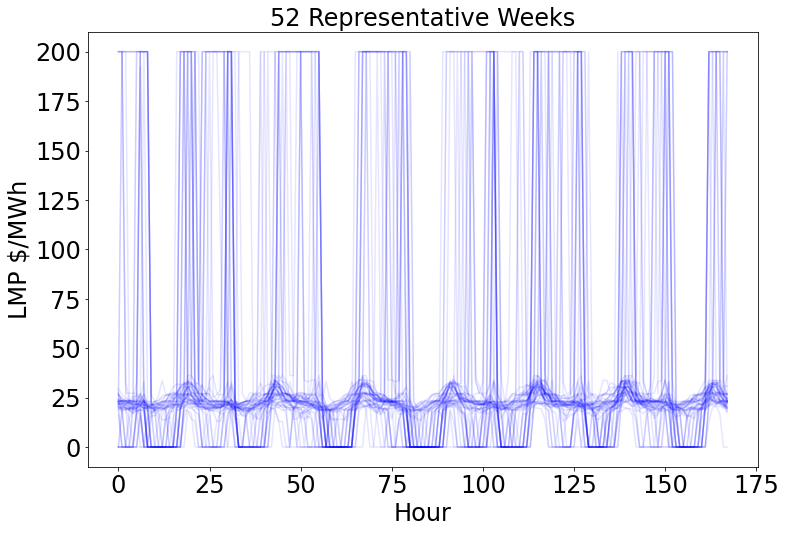

In [6]:
plt.figure(figsize=(12,8));
for week in range(0,52):
    plt.plot(weekly_prices[week],color = "blue", alpha = 0.1);
plt.title("52 Representative Weeks")
plt.xlabel("Hour");
plt.ylabel("LMP $/MWh");

# 3.) Create a Multiperiod-Capable Rankine Cycle Model

This is how a user should extend their steady-state process model to include time coupling.:  
1.) Decide which variables are coupled between time periods. These are variables which will include time-coupling constraints (e.g. ramping)  
2.) Create a function that builds a multi-period capable steady-state model (see code snippet 3.1)  
3.) Create functions that access the coupling variables given two pyomo blocks (see code snippet 3.2)

## 3.1) User-Defined Model Builder Function

This is passed to `MultiPeriodModel`. The user creates their steady-state model and then adds the extra capabilities for a multi-period version for a specific time period

In [7]:
turbine_ramp_rate = 100
battery_ramp_rate = 50
def create_mp_rankine_block():
    m = create_ss_rankine_model();
    b1 = m.rankine

    #Add coupling variable (next_power_output) to represent power output in next time period
    b1.power_output = pyo.Expression(expr = b1.fs.net_cycle_power_output*1e-6)  #MW
    b1.next_power_output = pyo.Var(within=pyo.NonNegativeReals, initialize=1.5) #MW

    #Use coupling variable to add ramping constraint
    b1.ramp1 = pyo.Constraint(expr=b1.power_output - b1.next_power_output <= turbine_ramp_rate)
    b1.ramp2 = pyo.Constraint(expr=b1.next_power_output - b1.power_output <= turbine_ramp_rate)

    #Add battery integration to rankine cycle
    b1.P_to_battery = pyo.Var(within=pyo.NonNegativeReals,initialize = 0.0) 
    b1.P_to_grid = pyo.Var(within=pyo.NonNegativeReals,initialize = 0.0)
    b1.P_total = pyo.Constraint(expr = b1.power_output == b1.P_to_battery + b1.P_to_grid)

    #Simple battery model (soc = state of charge). We create a coupling variable called next_soc
    m.battery = pyo.Block()
    b2=m.battery
    
    #soc = state of charge
    b2.soc = pyo.Var(within=pyo.NonNegativeReals,initialize=0.0, bounds=(0,100))
    b2.next_soc = pyo.Var(within=pyo.NonNegativeReals,initialize=0.0, bounds=(0,100))

    #Amount discharged to grid this time period (assume discharge is positive)
    b2.efficiency = np.sqrt(0.88)
    b2.discharge = pyo.Var(initialize = 0.0)
    b2.energy_change = pyo.Constraint(expr = b2.next_soc == b2.soc - b2.discharge/b2.efficiency + b1.P_to_battery*b2.efficiency)
    b2.energy_down_ramp = pyo.Constraint(expr = b2.soc - b2.next_soc <= battery_ramp_rate)
    b2.energy_up_ramp = pyo.Constraint(expr = b2.next_soc - b2.soc <= battery_ramp_rate)
    return m

## 3.2) User-Defined Coupling Variable Functions

These functions also get passed to `MultiPeriodModel`. They are used to enforce coupling between time periods (get_rankine_link_variable_pairs) and enforce periodic conditions (get_rankine_periodic_variable_pairs)

In [8]:
#the power output and battery state are linked between time periods
def get_rankine_link_variable_pairs(t1,t2):
    """
        t1: current time block
        t2: next time block
    """
    return [(t1.rankine.next_power_output,t2.rankine.power_output),
            (t1.battery.next_soc,t2.battery.soc)]

#the final power output and battery state must be the same as the intial power output and battery state
def get_rankine_periodic_variable_pairs(t1,t2):
    """
        t1: final time block
        t2: first time block
    """
    return [(t1.battery.next_soc,t2.battery.soc)]

# 4.) Create MultiPeriod Price-Taker Problem

Here we create the `MultiPeriodModel` using the developed functions. We assume a 1 week time period which creates 168 time blocks.

In [9]:
n_time_points = 7*24 #hours in a week

#create the multiperiod model object
mp_rankine = MultiPeriodModel(n_time_points=n_time_points, 
                              process_model_func=create_mp_rankine_block, 
                              linking_variable_func=get_rankine_link_variable_pairs,
                              periodic_variable_func = get_rankine_periodic_variable_pairs)

In [10]:
#you can pass arguments to your `process_model_func` for each time period using a dict of dicts as shown here. 
#In this case, it is setting up empty dictionaries for each time period.

# OPTIONAL KEYWORD ARGUMENTS
# time_points = np.arange(0,n_time_points)
# data_points = [{} for i in range(n_time_points)]
# data_kwargs = dict(zip(time_points,data_points))
# mp_rankine.build_multi_period_model(data_kwargs);

#if you have no arguments, you don't actually need to pass in anything.
mp_rankine.build_multi_period_model();
#NOTE: building the model will initialize each time block. it will take a few minutes

2021-09-16 17:31:16 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:31:16 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:16 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:16 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:31:16 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:16 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:31:16 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:16 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:31:16 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31

2021-09-16 17:31:19 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:31:19 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:19 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:19 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:31:19 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:19 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:31:19 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:19 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:31:19 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31

2021-09-16 17:31:21 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:31:21 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:21 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:21 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:31:21 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:21 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:31:21 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:21 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:31:22 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31

2021-09-16 17:31:23 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:31:23 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:24 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:24 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:31:24 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:24 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:31:24 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:24 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:31:24 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31

2021-09-16 17:31:26 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:31:26 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:26 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:26 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:31:26 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:26 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:31:26 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:26 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:31:26 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31

2021-09-16 17:31:27 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:31:27 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:27 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:27 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:31:27 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:27 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:31:28 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:28 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:31:28 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31

2021-09-16 17:31:29 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:31:29 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:29 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:29 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:31:29 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:29 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:31:29 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:29 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:31:29 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31

2021-09-16 17:31:30 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:31:31 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:31 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:31 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:31:31 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:31 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:31:31 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:31 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:31:31 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31

2021-09-16 17:31:32 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:31:33 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:33 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:33 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:31:33 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:33 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:31:33 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:33 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:31:33 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31

2021-09-16 17:31:35 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:31:35 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:35 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:35 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:31:35 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:35 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:31:35 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:35 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:31:35 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31

2021-09-16 17:31:37 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:31:37 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:37 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:37 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:31:37 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:37 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:31:37 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:37 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:31:38 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31

2021-09-16 17:31:40 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:31:40 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:40 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:40 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:31:40 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:40 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:31:40 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:40 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:31:40 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31

2021-09-16 17:31:42 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:31:42 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:42 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:42 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:31:42 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:42 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:31:42 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:42 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:31:42 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31

2021-09-16 17:31:44 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:31:44 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:44 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:44 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:31:44 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:44 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:31:44 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:44 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:31:44 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31

2021-09-16 17:31:45 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:31:45 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:46 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:46 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:31:46 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:46 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:31:46 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:46 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:31:46 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31

2021-09-16 17:31:47 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:31:47 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:47 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:47 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:31:47 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:47 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:31:47 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:47 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:31:47 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31

2021-09-16 17:31:49 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:31:49 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:49 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:49 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:31:49 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:49 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:31:49 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:49 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:31:49 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31

2021-09-16 17:31:50 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:31:50 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:50 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:50 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:31:50 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:50 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:31:50 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:50 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:31:51 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31

2021-09-16 17:31:52 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:31:52 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:53 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:53 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:31:53 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:53 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:31:53 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:53 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:31:53 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31

2021-09-16 17:31:54 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:31:54 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:55 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:55 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:31:55 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:55 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:31:55 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:55 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:31:55 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31

2021-09-16 17:31:56 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:31:56 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:56 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:57 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:31:57 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:57 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:31:57 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:57 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:31:57 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31

2021-09-16 17:31:59 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:31:59 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:59 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:59 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:31:59 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:59 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:31:59 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31:59 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:31:59 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:31

2021-09-16 17:32:01 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:32:01 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:01 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:01 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:32:01 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:01 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:32:01 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:01 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:32:02 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32

2021-09-16 17:32:03 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:32:03 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:03 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:03 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:32:03 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:03 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:32:03 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:03 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:32:03 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32

2021-09-16 17:32:06 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:32:06 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:06 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:06 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:32:06 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:06 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:32:06 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:06 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:32:06 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32

2021-09-16 17:32:09 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:32:09 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:09 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:09 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:32:09 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:09 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:32:09 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:09 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:32:10 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32

2021-09-16 17:32:12 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:32:12 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:12 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:12 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:32:12 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:12 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:32:12 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:12 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:32:12 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32

2021-09-16 17:32:13 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:32:13 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:13 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:13 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:32:14 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:14 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:32:14 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:14 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:32:14 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32

2021-09-16 17:32:15 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:32:15 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:15 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:15 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:32:15 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:15 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:32:15 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:15 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:32:15 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32

2021-09-16 17:32:17 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:32:17 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:17 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:17 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:32:17 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:17 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:32:17 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:17 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:32:17 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32

2021-09-16 17:32:18 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:32:18 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:18 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:18 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:32:18 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:18 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:32:18 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:18 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:32:18 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32

2021-09-16 17:32:20 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:32:20 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:20 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:20 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:32:20 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:20 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:32:20 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:20 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:32:20 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32

2021-09-16 17:32:22 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:32:22 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:22 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:22 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:32:22 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:22 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:32:22 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:22 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:32:22 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32

2021-09-16 17:32:23 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:32:23 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:23 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:23 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:32:24 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:24 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:32:24 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:24 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:32:24 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32

2021-09-16 17:32:25 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:32:25 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:25 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:25 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:32:25 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:25 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:32:25 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:25 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:32:25 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32

2021-09-16 17:32:27 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:32:27 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:27 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:27 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:32:27 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:27 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:32:27 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:27 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:32:27 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32

2021-09-16 17:32:29 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:32:29 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:29 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:29 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:32:29 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:29 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:32:29 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:29 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:32:29 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32

2021-09-16 17:32:30 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:32:30 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:30 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:30 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:32:30 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:30 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:32:30 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:31 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:32:31 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32

2021-09-16 17:32:32 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:32:32 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:32 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:32 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:32:32 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:32 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:32:32 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:32 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:32:32 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32

2021-09-16 17:32:34 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:32:34 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:34 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:34 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:32:34 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:34 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:32:34 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:34 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:32:34 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32

2021-09-16 17:32:36 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:32:36 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:36 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:36 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:32:36 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:36 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:32:36 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:36 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:32:36 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32

2021-09-16 17:32:38 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:32:38 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:38 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:38 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:32:38 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:38 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:32:38 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:38 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:32:38 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32

2021-09-16 17:32:40 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:32:40 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:40 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:40 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:32:40 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:40 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:32:40 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:40 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:32:40 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32

2021-09-16 17:32:42 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:32:42 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:42 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:42 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:32:42 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:42 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:32:43 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:43 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:32:43 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32

2021-09-16 17:32:44 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:32:44 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:44 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:44 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:32:44 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:44 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:32:44 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:44 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:32:44 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32

2021-09-16 17:32:46 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:32:46 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:46 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:46 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:32:46 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:46 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:32:46 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:46 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:32:46 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32

2021-09-16 17:32:47 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:32:47 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:47 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:47 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:32:47 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:47 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:32:48 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:48 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:32:48 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32

2021-09-16 17:32:49 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:32:49 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:49 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:49 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:32:49 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:49 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:32:49 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:49 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:32:49 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32

2021-09-16 17:32:51 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:32:51 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:51 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:51 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:32:51 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:51 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:32:51 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:51 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:32:51 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32

2021-09-16 17:32:52 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:32:52 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:52 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:52 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:32:53 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:53 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:32:53 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:53 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:32:53 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32

2021-09-16 17:32:54 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:32:54 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:54 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:54 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:32:54 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:54 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:32:54 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:54 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:32:54 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32

2021-09-16 17:32:56 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:32:56 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:56 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:56 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:32:57 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:57 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:32:57 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:57 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:32:57 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32

2021-09-16 17:32:58 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:32:58 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:58 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:58 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:32:58 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:58 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:32:58 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32:58 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:32:58 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:32

2021-09-16 17:33:00 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:33:00 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:00 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:00 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:33:00 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:00 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:33:00 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:00 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:33:00 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33

2021-09-16 17:33:02 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:33:02 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:02 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:02 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:33:02 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:02 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:33:02 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:02 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:33:02 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33

2021-09-16 17:33:03 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:33:03 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:04 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:04 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:33:04 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:04 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:33:04 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:04 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:33:04 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33

2021-09-16 17:33:06 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:33:06 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:06 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:06 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:33:06 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:06 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:33:06 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:06 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:33:06 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33

2021-09-16 17:33:08 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:33:08 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:08 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:08 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:33:08 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:08 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:33:08 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:08 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:33:08 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33

2021-09-16 17:33:09 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:33:09 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:10 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:10 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:33:10 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:10 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:33:10 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:10 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:33:10 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33

2021-09-16 17:33:11 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:33:11 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:12 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:12 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:33:12 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:12 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:33:12 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:12 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:33:12 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33

2021-09-16 17:33:13 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:33:13 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:14 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:14 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:33:14 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:14 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:33:14 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:14 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:33:14 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33

2021-09-16 17:33:15 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:33:15 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:15 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:15 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:33:15 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:16 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:33:16 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:16 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:33:16 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33

2021-09-16 17:33:17 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:33:17 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:17 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:17 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:33:17 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:17 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:33:17 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:17 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:33:18 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33

2021-09-16 17:33:19 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:33:19 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:19 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:19 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:33:19 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:19 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:33:20 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:20 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:33:20 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33

2021-09-16 17:33:22 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:33:22 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:22 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:22 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:33:22 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:22 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:33:22 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:22 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:33:22 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33

2021-09-16 17:33:24 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:33:24 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:24 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:24 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:33:24 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:24 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:33:24 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:24 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:33:24 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33

2021-09-16 17:33:26 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:33:26 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:26 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:26 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:33:26 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:26 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:33:26 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:26 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:33:27 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33

2021-09-16 17:33:28 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:33:28 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:28 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:28 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:33:29 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:29 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:33:29 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:29 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:33:29 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33

2021-09-16 17:33:30 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:33:31 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:31 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:31 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:33:31 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:31 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:33:31 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:31 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:33:31 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33

2021-09-16 17:33:33 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:33:33 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:33 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:33 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:33:33 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:33 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:33:33 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:33 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:33:33 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33

2021-09-16 17:33:35 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:33:36 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:36 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:36 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:33:36 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:36 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:33:36 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:36 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:33:36 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33

2021-09-16 17:33:38 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:33:38 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:38 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:38 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:33:38 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:38 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:33:38 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:38 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:33:38 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33

2021-09-16 17:33:40 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:33:40 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:40 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:40 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:33:40 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:40 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:33:40 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:40 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:33:40 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33

2021-09-16 17:33:42 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:33:42 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:42 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:42 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:33:42 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:42 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:33:42 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:42 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:33:42 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33

2021-09-16 17:33:44 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:33:44 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:44 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:44 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:33:44 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:44 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:33:44 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:44 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:33:44 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33

2021-09-16 17:33:46 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:33:46 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:46 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:46 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:33:47 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:47 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:33:47 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:47 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:33:47 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33

2021-09-16 17:33:48 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:33:49 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:49 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:49 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:33:49 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:49 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:33:49 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:49 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:33:49 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33

2021-09-16 17:33:51 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:33:51 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:51 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:51 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:33:51 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:51 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:33:51 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:51 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:33:51 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33

2021-09-16 17:33:53 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:33:53 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:53 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:53 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:33:53 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:53 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:33:53 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:53 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:33:53 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33

2021-09-16 17:33:55 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:33:55 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:55 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:55 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:33:56 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:56 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:33:56 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:56 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:33:56 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33

2021-09-16 17:33:59 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:33:59 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:59 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:59 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:33:59 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:59 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:33:59 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33:59 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:33:59 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:33

2021-09-16 17:34:01 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:34:01 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:34:01 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:34:01 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:34:01 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:34:01 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:34:01 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:34:01 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:34:02 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:34

2021-09-16 17:34:03 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:34:03 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:34:04 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:34:04 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:34:04 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:34:04 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:34:04 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:34:04 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:34:04 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:34

2021-09-16 17:34:08 [INFO] idaes.init.rankine.fs.boiler.control_volume: Initialization Complete
2021-09-16 17:34:08 [INFO] idaes.init.rankine.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:34:08 [INFO] idaes.init.rankine.fs.turbine: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:34:08 [INFO] idaes.init.rankine.fs.pre_condenser.control_volume: Initialization Complete
2021-09-16 17:34:08 [INFO] idaes.init.rankine.fs.pre_condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:34:08 [INFO] idaes.init.rankine.fs.condenser.control_volume: Initialization Complete
2021-09-16 17:34:09 [INFO] idaes.init.rankine.fs.condenser: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:34:09 [INFO] idaes.init.rankine.fs.bfw_pump.control_volume: Initialization Complete
2021-09-16 17:34:09 [INFO] idaes.init.rankine.fs.bfw_pump: Initialization Complete: optimal - Optimal Solution Found
2021-09-16 17:34

## 4.1) Setup grid objective function and data

Now we query the produced pyomo blocks and create a LMP signal parameter on each block. We also add expressions for revenue (using plant dispatch and LMP) and cost (which is function of power output). We set the objective function to the summation of time period costs and also fix the initial battery state to initially be zero charge.

In [11]:
#retrieve pyomo model and active process blocks (i.e. time blocks)
m = mp_rankine.pyomo_model
blks = mp_rankine.get_active_process_blocks()

#add market data for each block
for blk in blks:
    blk_rankine = blk.rankine
    blk_battery = blk.battery
    blk.lmp_signal = pyo.Param(default=0,mutable=True)
    blk.revenue = blk.lmp_signal*(blk_rankine.P_to_grid + blk_battery.discharge)
    blk.cost = pyo.Expression(expr=-(blk.revenue - blk_rankine.fs.operating_cost))

m.obj = pyo.Objective(expr = sum([blk.cost for blk in blks]))
blks[0].battery.soc.fix(0);

## 4.2) Run the price-taker model

We run the price-taker model for 3 weeks by swapping out the LMP signal for each week and solving a new problem. This is generally a close approximation to running the entire year (if we set `n_weeks` to 52) because the only added constraint is a weekly periodic boundary condition (i.e. the power and battery state must get back to their initial value by end of the week)

We also record the state-of-charge `soc` and net power `net_power` for each optimization problem to plot later

In [12]:
n_weeks = 3
opt = pyo.SolverFactory('ipopt')
soc = []
net_power = []

for week in range(n_weeks):
    print("Solving for week: ", week)
    for (i,blk) in enumerate(blks):
        blk.lmp_signal = weekly_prices[week][i]    
    opt.solve(m,tee=False)
    soc.append([pyo.value(blks[i].battery.soc) for i in range(n_time_points)])
    net_power.append([pyo.value(blks[i].rankine.power_output) for i in range(n_time_points)])

Solving for week:  0
Solving for week:  1
Solving for week:  2


## 4.3) Plot Battery State-of-Charge and LMP 

Plot the battery state for 1 week of operation. This should show that the battery is frequently utilized throughout each day.

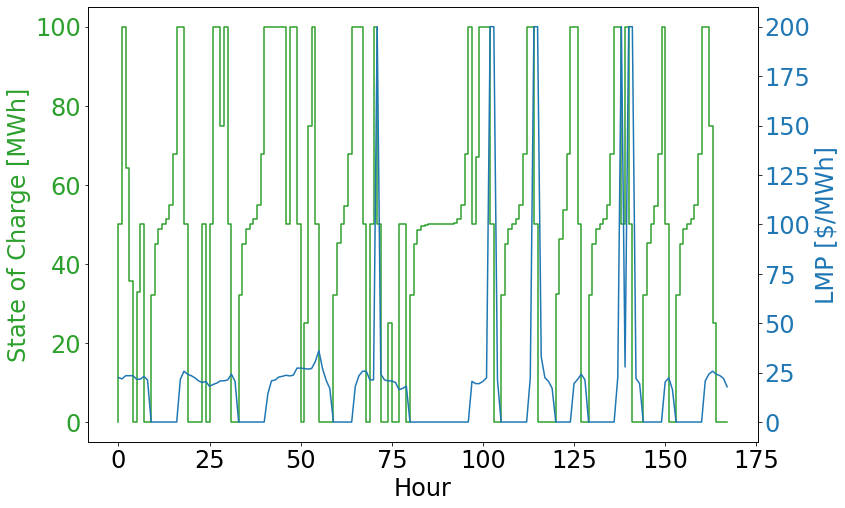

In [13]:
n_weeks_to_plot = 1;
hours = np.arange(n_time_points*n_weeks_to_plot);
lmp_array = weekly_prices[0:n_weeks_to_plot].flatten();
soc_array = np.asarray(soc[0:n_weeks_to_plot]).flatten();

fig, ax1 = plt.subplots(figsize=(12,8));

color = 'tab:green';
ax1.set_xlabel('Hour');
ax1.set_ylabel('State of Charge [MWh]', color=color);
ax1.step(hours,soc_array, color=color);
ax1.tick_params(axis='y', labelcolor=color);

ax2 = ax1.twinx();  
color = 'tab:blue';
ax2.set_ylabel('LMP [$/MWh]', color=color);
ax2.plot(hours,lmp_array, color=color);
ax2.tick_params(axis='y', labelcolor=color);

## 4.4) Plot Power-Output and LMP 

Plot the hourly power output. This should show the output tracks price spikes.

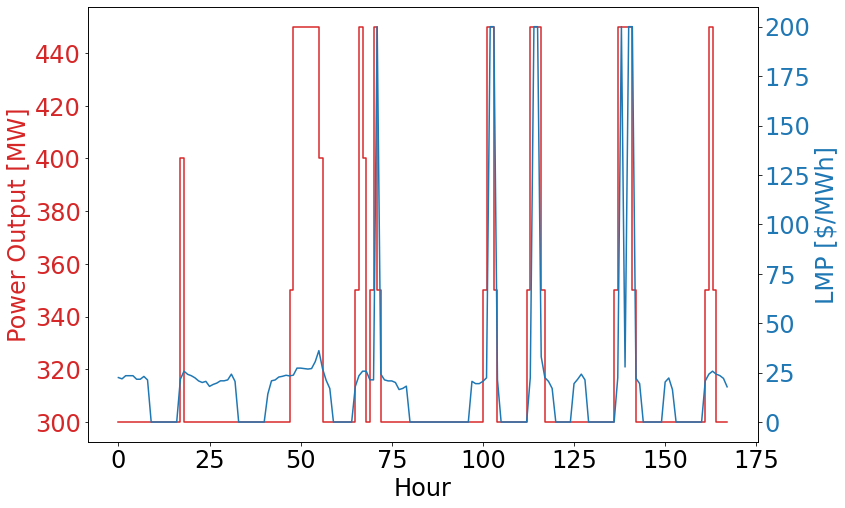

In [14]:
n_weeks_to_plot = 1;
hours = np.arange(n_time_points*n_weeks_to_plot);
lmp_array = weekly_prices[0:n_weeks_to_plot].flatten();
power_array = np.asarray(net_power[0:n_weeks_to_plot]).flatten();

fig, ax1 = plt.subplots(figsize=(12,8));

color = 'tab:red';
ax1.set_xlabel('Hour');
ax1.set_ylabel('Power Output [MW]', color=color);
ax1.step(hours,power_array, color=color);
ax1.tick_params(axis='y', labelcolor=color);

ax2 = ax1.twinx();  
color = 'tab:blue';
ax2.set_ylabel('LMP [$/MWh]', color=color);
ax2.plot(hours,lmp_array, color=color);
ax2.tick_params(axis='y', labelcolor=color);